In [1]:
# , TaskLoader, construct_circ_time_ds
from deepsensor.data import DataProcessor
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import lab as B
import numpy as np
import torch.optim as optim
from tqdm import tqdm_notebook, tqdm
import pandas as pd
import xarray as xr
from deepsensor.data import TaskLoader
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.model import ConvNP
import deepsensor.torch
import logging
import copy
logging.captureWarnings(True)
from typing import Union, Tuple, List


/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:44: DeprecationWa

Normalisation params for sea_ice_concentration not computed. Computing now... Done. sea_ice_concentration mean_std params={'mean': 65.84078216552734, 'std': 41.97758102416992}
Inferring x1_map=(820052.4534908909, 1757308.9192756172) and x2_map=(-2625435.9375827303, -1688179.4717980041) from data min/max


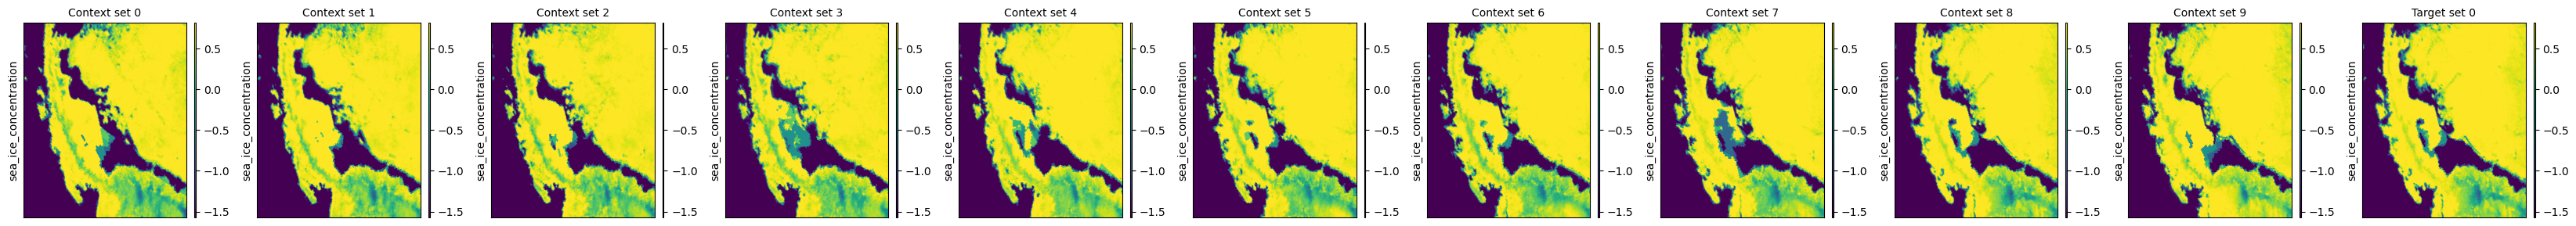

<xarray.Dataset>
Dimensions:                (time: 40, y: 250, x: 300)
Coordinates:
  * y                      (y) float64 8.201e+05 8.232e+05 ... 1.601e+06
  * x                      (x) float64 -2.625e+06 -2.622e+06 ... -1.688e+06
  * time                   (time) datetime64[ns] 2021-10-20 ... 2021-11-28
Data variables:
    sea_ice_concentration  (time, y, x) float32 ...
Attributes: (12/17)
    title:              Daily averaged Antarctic sea ice concentration derive...
    description:        gridded ASI AMSR2 sea ice concentration
    history:            Created Thu Oct 21 12:21:07 2021
    sensor:             AMSR2
    datasource:         JAXA L1R v2
    netCDF_created_by:  Xiangshan Tian-Kunze, xiangshan.tiankunze@awi.de
    ...                 ...
    grid:               NSIDC polar stereographic with tangential plane at 70...
    grid_resolution:    3.125 km
    Comment:            List of swath files used for the daily mean: ['GW1AM2...
    geocorrection:      none
    contact:            xiangshan.tiankunze@awi.de
    Summary:            The land is not masked out in the data. The user shou...

In [2]:
# Open Netcdf of MODIS-derived SIC with cloud mask
sic_raw_ds = xr.open_dataset("/data/hpcdata/users/marrog/DeepSensor_code/MODIS_SIC_stack_1kmRes.nc")

# Open netcdf of AMSR derived SIC
amsr_raw_ds = xr.open_dataset(
    "/data/hpcdata/users/marrog/DeepSensor_code/sea_ice_code/SIC_amsr_stack_3031_time_temp5.nc")

# Remove land mask
# Todo- make this an auxillar variable in case I subsequently want to use it.
amsr_raw_ds = amsr_raw_ds.drop(['land'])
amsr_raw_subset = amsr_raw_ds.isel(y = slice(0,250), x = slice(0,300))
# dataprocessor
data_processor = DataProcessor(x1_name="y", x2_name="x", verbose=True)
#modis_ds, amsr_ds = data_processor([sic_raw_ds, amsr_raw_ds])
amsr_ds= data_processor(amsr_raw_subset)

# Instantiate task loader
task_loader = TaskLoader(
    context = [amsr_ds]*10,
    target = [amsr_ds],
    context_delta_t = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1], 
    target_delta_t = 0
)

task = task_loader("2021-11-24", context_sampling= ["all", "all","all","all", "all","all", "all","all", "all","all"] , target_sampling="all")

fig = deepsensor.plot.task(task, task_loader)
plt.show()
amsr_raw_subset

In [3]:
# Generate patched tasks
# Note when using patching strategy, task comes back as a list of task objects.
train_tasks = []
for date in pd.date_range("2021-10-28", "2021-11-27"):
    task = task_loader(date, context_sampling= ["all", "all","all","all", "all","all", "all","all", "all","all"] , target_sampling="all")

    task.remove_context_nans().remove_target_nans()
    train_tasks.append(task)

In [4]:
# Set up model
model = ConvNP(data_processor, task_loader, likelihood="gnp")
opt = optim.Adam(model.model.parameters(), lr=5e-5)

dim_yc inferred from TaskLoader: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 299
encoder_scales inferred from TaskLoader: [0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737, 0.0016722407890483737]
decoder_scale inferred from TaskLoader: 0.0033444816053511705


In [5]:
# Calculate the number of tasks
task_count = len(train_tasks)
print(' task count', task_count) ### to do, change this code to work when task is a list of patched tasks per day.
# Produce list [0, task_count]
task_entries = list(range(0, task_count))
print('task entries', task_entries)
# Permute list to assign order tasks applied to model
tasks_shuffled = np.random.permutation(task_entries)
print('task shuffled', tasks_shuffled)
# Set the number of tasks in each sublist
len_sublist = 3

# Split the original list into sublists
# sublists = task ids for each sublist of tasks
sublists = [tasks_shuffled[i:i+len_sublist]
            for i in range(0, len(tasks_shuffled), len_sublist)]
print(sublists)

n_epochs = 30

# Train model
trainer = Trainer(model, lr=5e-5)
for epoch in tqdm(range(n_epochs)):
    batch_losses = trainer(train_tasks, batch_size = 8)

 task count 31
task entries [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
task shuffled [23  8  0 19  9 13 22  5  2 30 25 29 16 12 14 27  7 26 15 21 18 24 11  1
 28 17 10  3  6 20  4]
[array([23,  8,  0]), array([19,  9, 13]), array([22,  5,  2]), array([30, 25, 29]), array([16, 12, 14]), array([27,  7, 26]), array([15, 21, 18]), array([24, 11,  1]), array([28, 17, 10]), array([ 3,  6, 20]), array([4])]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [06:44<00:00, 13.48s/it]


In [6]:
test_date = "2021-11-24"

test_task_whole = task_loader(test_date,  context_sampling= ["all", "all","all","all", "all","all", "all","all", "all","all"] , target_sampling="all")

# Note, data_processor is an obligatory input for predict_patch
prediction = model.predict(test_task_whole, X_t=amsr_raw_subset)
test_task_whole

time: Timestamp/2021-11-24 00:00:00
ops: []
bbox: None
X_c: [('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)'), ('ndarray/float32/(1, 250)', 'ndarray/float32/(1, 300)')]
Y_c: ['ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)', 'ndarray/float32/(1, 250, 300)']
X_t: [('ndarray/float32

In [7]:
cov_new = model.covariance(test_task_whole)
cov_new

array([[2.0628374 , 0.00622304, 0.00644815, ..., 0.00439897, 0.00430961,
        0.00406978],
       [0.00622304, 2.203598  , 0.00694852, ..., 0.00471831, 0.00462038,
        0.00435153],
       [0.00644815, 0.00694852, 2.312335  , ..., 0.00492044, 0.00481661,
        0.00453131],
       ...,
       [0.00439897, 0.00471831, 0.00492044, ..., 1.5075676 , 0.00391162,
        0.00367442],
       [0.00430961, 0.00462038, 0.00481661, ..., 0.00391162, 1.4982151 ,
        0.00360873],
       [0.00406978, 0.00435153, 0.00453131, ..., 0.00367442, 0.00360873,
        1.4438056 ]], dtype=float32)

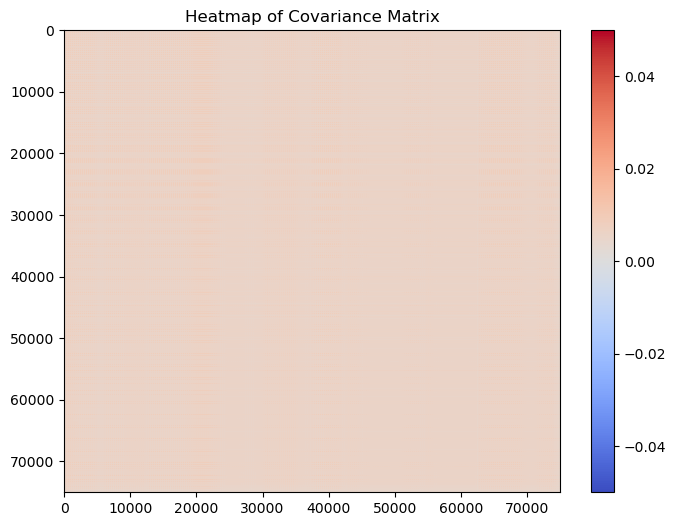

In [8]:
#small_cov = cov[0:100, 0:100]
plt.figure(figsize=(8, 6))
plt.imshow(cov_new, cmap='coolwarm', interpolation='none', aspect='auto', vmin=-0.05, vmax=0.05)
plt.colorbar()

# Add labels
plt.title('Heatmap of Covariance Matrix')
plt.show()

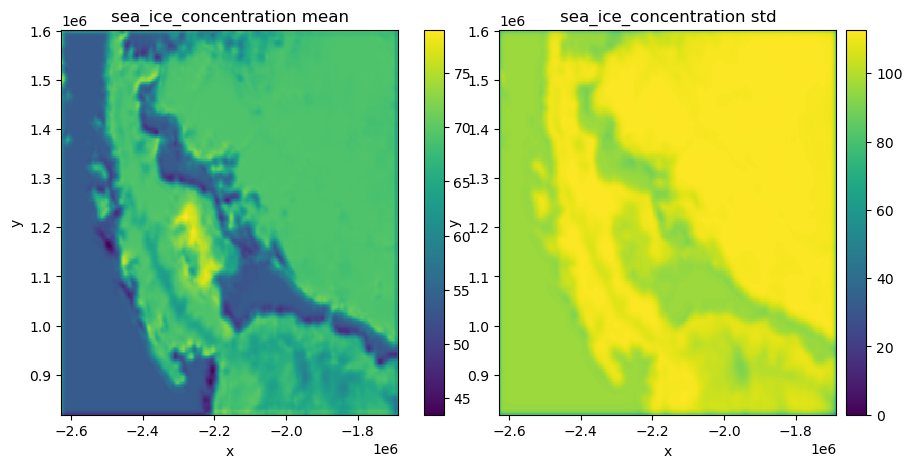

In [125]:
deepsensor.plot.prediction(prediction, test_date)

In [9]:
# chose a location, plo covariances around there. 
# Compute the sum of each row
row_sums = np.sum(cov_new, axis=1)

# Find the index of the row with the maximum sum
max_sum_index = np.argmax(row_sums)

# Get the row with the highest sum
max_sum_row = cov_new[max_sum_index]
#pixel_cov = cov

44220
147.4


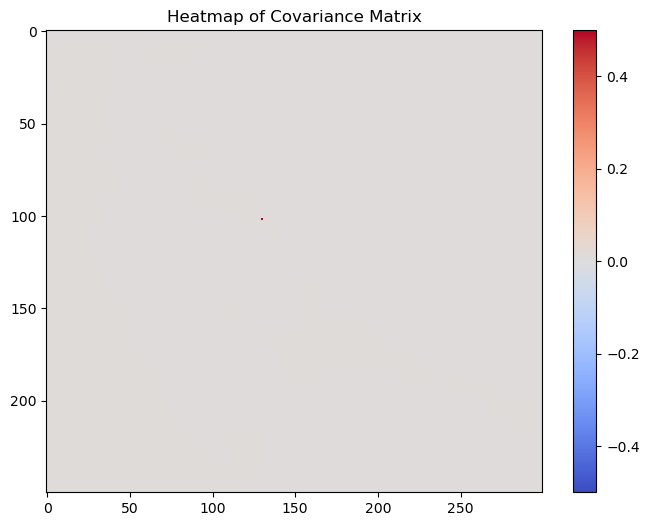

In [23]:
print(max_sum_index)
print(max_sum_index/300)
max_sum_trial = cov_new[44230]
max_row_resize = np.flip(max_sum_trial.reshape((250,300)), axis = 0)
plt.figure(figsize=(8, 6))
plt.imshow(max_row_resize, cmap='coolwarm', interpolation='none', aspect='auto', vmin=-0.5, vmax=0.5)
plt.colorbar()

# Add labels
plt.title('Heatmap of Covariance Matrix')
plt.show()

In [10]:
p_row = 0
y_val = prediction[0][0]['mean'].coords['y'].min()    
print(y_val)
for p in preds:
    print(p[0]['mean'].coords['y'].min())
    if p[0]['mean'].coords['y'].min() == y_val:
        p_row = p_row+1

KeyError: "No variable named 0. Variables on the dataset include ['mean', 'std', 'y', 'x', 'time']"

In [ ]:
date = "2021-11-24"
fig = deepsensor.plot.prediction(prediction, date)

: 

In [ ]:
prediction

: 

In [ ]:
# Set up model
# Internal_density works similar to the manual pooling task I was previously conducting.
# It effectively reduces the resolution and thus size of the images.
# Hopefully this step can be removed once patching is in place.
opt = optim.Adam(model.model.parameters(), lr=5e-5)

# Calculate the number of tasks
task_count = len(train_tasks[0])
print(task_count) ### to do, change this code to work when task is a list of patched tasks per day.
# Produce list [0, task_count]
task_entries = list(range(0, task_count))

# Permute list to assign order tasks applied to model
tasks_shuffled = np.random.permutation(task_entries)

# Set the number of tasks in each sublist
len_sublist = 3

# Split the original list into sublists
sublists = [tasks_shuffled[i:i+len_sublist]
            for i in range(0, len(tasks_shuffled), len_sublist)]
print(sublists)

n_epochs = 3

# Train model
for epoch in tqdm(range(n_epochs)):
    for sublist in sublists:  # currently sublist is a subset of 3 of the tasks
        task_losses = []
        for i in sublist:
            print(i)
            task_i = train_tasks[i]
            opt.zero_grad()
            task_losses.append(model.loss_fn(task_i, normalise=True))
        mean_batch_loss = B.mean(B.stack(*task_losses))
        mean_batch_loss.backward()
        opt.step()


: 

In [ ]:
import rasterio
from rasterio.plot import show
from affine import Affine
# Save the DataArray as a TIFF file
output_tiff_path = 'combined_output_two_var_20211124.tiff'
# Define the transform and CRS (Coordinate Reference System)
im_transform = (-2627584.0, 256.0, 0.0, 1838592.0, 0.0, -256.0)

afn = Affine.from_gdal(*im_transform)
# Define the transform and CRS (Coordinate Reference System)
#transform = from_origin(0, 10, 1, 1)  # Example transform (origin_x, origin_y, pixel_size_x, pixel_size_y)
crs = 'EPSG:3031'  # Example CRS (WGS84)
arr_combined = np.asarray(prediction['sic']['mean'].values)
arr_combined = np.flip(arr_combined.squeeze(0), axis = 0)
show(arr_combined)
print(arr_combined.shape)
# Save using rasterio


with rasterio.open(
    output_tiff_path, 'w', driver='GTiff',
    height=arr_combined.shape[0], width=arr_combined.shape[1],
    count=1, dtype=arr_combined.dtype, transform = afn,
    crs=crs) as dst:
    dst.write(arr_combined, 1)

: 

In [ ]:
### Full size pred for comparison
test_task_no_patch = task_loader("2021-11-24", context_sampling=["all", "all"], target_sampling="all")
pred_entire = loaded_model.predict(test_task_no_patch, X_t=amsr_raw_ds)


dates = pd.date_range("2021-10-22", "2021-10-25")

test_task_no_patch = task_loader(dates, context_sampling=["all", "all"], target_sampling="all")
predictions = model.predict(test_task_no_patch, X_t= amsr_raw_ds)

: 

In [ ]:
patch_size = (0.25, 0.25)
stride = (0.2, 0.2)
dates = pd.date_range("2021-10-22", "2021-10-25")

test_task = task_loader(dates, context_sampling=["all", "all"], target_sampling="all",
                        patch_strategy="sliding", patch_size=patch_size, stride=stride)
predictions = model.predict_patch(test_task_no_patch, X_t= amsr_raw_ds, data_processor = data_processor, patch_size = patch_size, stride_size = stride)

: 

In [ ]:
date = "2021-10-24"
fig = deepsensor.plot.prediction(predictions, date)

: 

In [ ]:
def get_patches_per_row(preds):
    """
    Calculate number of patches per row. 
    Required to stitch patches back together. 
    Args:
        preds (List[class:`~.model.pred.Prediction`]):
                A list of `dict`-like objects containing patchwise predictions.
    
    Returns:
        patches_per_row (int)
            Number of patches per row.
    """   
    patches_per_row = 0
    vars = list(preds[0][0].data_vars)
    var = vars[0]        
        
    for p in preds:
        if p[0][var].coords['y'].min() == amsr_raw_ds.coords['y'].min():
            patches_per_row = patches_per_row + 1  
    return patches_per_row

patches_per_row = get_patches_per_row(preds)


: 

In [ ]:
# Calculate overlap between adjacent patches in pixels
def get_patch_overlap(overlap_norm, data_processor, amsr_raw_ds):
    overlap_list = [0, overlap_norm[0], 0, overlap_norm[1]]
    x1 = xr.DataArray([overlap_list[0], overlap_list[1]], dims='x1', name='x1')
    x2 = xr.DataArray([overlap_list[2], overlap_list[3]], dims='x2', name='x2')
    overlap_norm_xr = xr.Dataset(coords={'x1': x1, 'x2': x2})
    
    # Unnormalise coordinates of bounding boxes
    overlap_unnorm_xr = data_processor.unnormalise(overlap_norm_xr)
    unnorm_overlap_x1 = overlap_unnorm_xr.coords['x'].values[1]
    unnorm_overlap_x2 = overlap_unnorm_xr.coords['y'].values[1]

    # Find the position of these indices within the DataArray
    x_overlap_index = int(np.ceil((np.argmin(np.abs(amsr_raw_ds.coords['x'].values - unnorm_overlap_x1))/2)))
    y_overlap_index = int(np.ceil((np.argmin(np.abs(amsr_raw_ds.coords['y'].values - unnorm_overlap_x2))/2)))

    return x_overlap_index, y_overlap_index

overlap_norm = tuple(patch - stride for patch, stride in zip(patch_size, stride))
x_overlap_index, y_overlap_index = get_patch_overlap(overlap_norm, data_processor, amsr_raw_ds)
patch_overlap = (x_overlap_index, y_overlap_index)
patch_overlap


: 

In [ ]:
def get_index(*args, x1 = True) -> Union[int, Tuple[List[int], List[int]]]:
    """
    Convert coordinates into pixel row/column (index).
    
    Parameters
    ----------
    args : tuple
        If one argument (numeric), it represents the coordinate value.
        If two arguments (lists), they represent lists of coordinate values.

    x1 : bool, optional
        If True, compute index for x1 (default is True).
    
    Returns
    -------
        Union[int, Tuple[List[int], List[int]]]
        If one argument is provided and x1 is True or False, returns the index position.
        If two arguments are provided, returns a tuple containing two lists:
        - First list: indices corresponding to x1 coordinates.
        - Second list: indices corresponding to x2 coordinates.  

    """
    if len(args) == 1:
        patch_coord = args
        if x1:
            coord_index = np.argmin(np.abs(amsr_raw_ds.coords['y'].values - patch_coord))
        else:
            coord_index = np.argmin(np.abs(amsr_raw_ds.coords['x'].values - patch_coord)) 
        return coord_index

    elif len(args) == 2:
        patch_x1, patch_x2 = args       
        x1_index = [np.argmin(np.abs(amsr_raw_ds.coords['y'].values - target_x1)) for target_x1 in patch_x1]           
        x2_index = [np.argmin(np.abs(amsr_raw_ds.coords['x'].values - target_x2)) for target_x2 in patch_x2]
        return (x1_index, x2_index)




: 

In [ ]:

data_x1 = amsr_raw_ds.coords['y'].min().values, amsr_raw_ds.coords['y'].max().values
data_x2 = amsr_raw_ds.coords['x'].min().values, amsr_raw_ds.coords['x'].max().values   
data_x1_index, data_x2_index = get_index(data_x1, data_x2)
patches_clipped = []

for i, patch_pred in enumerate(patch_preds):
    for var_name, data_array in patch_pred.items(): #previously patch
        if var_name in patch_pred:
            # Get row/col index values of each patch
            patch_x1 = data_array.coords['y'].min().values, data_array.coords['y'].max().values
            patch_x2 = data_array.coords['x'].min().values, data_array.coords['x'].max().values
            patch_x1_index, patch_x2_index =  get_index(patch_x1, patch_x2)
            
            b_x1_min, b_x1_max = patch_overlap[0], patch_overlap[0]
            b_x2_min, b_x2_max = patch_overlap[1], patch_overlap[1]
            # Do not remove border for the patches along top and left of dataset
            # and change overlap size for last patch in rows and columns.
            if patch_x2_index[0] == data_x2_index[0]:
                b_x2_min = 0
            elif patch_x2_index[1] == data_x2_index[1]:
                b_x2_max = 0
                patch_row_prev = preds[i-1]
                prev_patch_x2_max = get_index(int(patch_row_prev[var_name].coords['x'].max()), x1 = False)
                b_x2_min = (prev_patch_x2_max - patch_x2_index[0])-patch_overlap[1]

            if patch_x1_index[0] == data_x1_index[0]:
                b_x1_min = 0
            elif abs(patch_x1_index[1] - data_x1_index[1])<2:
                b_x1_max = 0
                patch_prev = preds[i-patches_per_row]
                prev_patch_x1_max = get_index(int(patch_prev[var_name].coords['y'].max()), x1 = True)
                b_x1_min = (prev_patch_x1_max - patch_x1_index[0])- patch_overlap[0]

            patch_clip_x1_min = int(b_x1_min)
            patch_clip_x1_max = int(data_array.sizes['y'] - b_x1_max)
            patch_clip_x2_min = int(b_x2_min)
            patch_clip_x2_max = int(data_array.sizes['x'] - b_x2_max)

            patch_clip = data_array.isel(y=slice(patch_clip_x1_min, patch_clip_x1_max),
                                         x=slice(patch_clip_x2_min, patch_clip_x2_max))

            patches_clipped.append(patch_clip)


: 

In [ ]:
combined = xr.combine_by_coords(patches_clipped, compat='no_conflicts')
combined['mean'].plot()
plt.show()
combined

: 

In [ ]:
import rasterio
from rasterio.plot import show
# Save the DataArray as a TIFF file
output_tiff_path = 'combined_output_20211124.tiff'
# Define the transform and CRS (Coordinate Reference System)
im_transform = (-2627584.0, 3125.0, 0.0, 1838592.0, 0.0, -3125.0)

afn = Affine.from_gdal(*im_transform)
# Define the transform and CRS (Coordinate Reference System)
#transform = from_origin(0, 10, 1, 1)  # Example transform (origin_x, origin_y, pixel_size_x, pixel_size_y)
crs = 'EPSG:3031'  # Example CRS (WGS84)
arr_combined = np.asarray(combined['mean'].values)
arr_combined = np.flip(arr_combined.squeeze(0), axis = 0)
show(arr_combined)
print(arr_combined.shape)
# Save using rasterio
#x1_map=(820052.4534908909, 2838808.8697723807) and x2_map=(-2625435.9375827303, -606679.5213012407) 
#raster_transform=[res,0,ul_x_sar, 0, -res, ul_y_sar]
transform = [3125, 0, -2625435.9375827303, 3125, 0, 820052.4534908909]  # Example transform (origin_x, origin_y, pixel_size_x, pixel_size_y)
with rasterio.open(
    output_tiff_path, 'w', driver='GTiff',
    height=arr_combined.shape[0], width=arr_combined.shape[1],
    count=1, dtype=arr_combined.dtype, transform = afn,
    crs=crs) as dst:
    dst.write(arr_combined, 1)

: 

In [ ]:
# compare patched to non-patched output
import rasterio
from rasterio.plot import show
from affine import Affine
test_task = task_loader("2021-11-24", context_sampling=["all", "all"], target_sampling="all")

# Note, i need to make data processor an obligatory input for predict_patch
pred = model.predict(test_task, X_t=amsr_raw_ds)
# Save the DataArray as a TIFF file
output_tiff_path = 'non_patched_output_20211124.tiff'

# Define the transform and CRS (Coordinate Reference System)
im_transform = (-2627584.0, 3125.0, 0.0, 1838592.0, 0.0, -3125.0)

afn = Affine.from_gdal(*im_transform)
crs = 'EPSG:3031'  # Example CRS (WGS84)
arr = np.asarray(pred['sea_ice_concentration']['mean'].values)
arr = np.flip(arr.squeeze(0), axis = 0)
show(arr)
print(arr.shape)
# Save using rasterio
with rasterio.open(
    output_tiff_path, 'w', driver='GTiff',
    height=arr.shape[0], width=arr.shape[1],
    count=1, dtype=arr.dtype, transform = afn,
    crs=crs) as dst:
    dst.write(arr, 1)

: 

In [ ]:
### Calculate difference between patched and array and one that predicts on entire extent ###
output_tiff_path = 'difference_patched_vs_entireExtent.tiff'
diff = arr_combined-arr
show(arr)
show(arr_combined)
show(diff)
print(arr.shape, arr_combined.shape)
with rasterio.open(
    output_tiff_path, 'w', driver='GTiff',
    height=diff.shape[0], width=diff.shape[1],
    count=1, dtype=diff.dtype, transform = afn,
    crs=crs) as dst:
    dst.write(diff, 1)

: 

In [ ]:
## Previous code in model.py
patches_clipped = []
    for i, patch in enumerate(patches):
    for var_name, data_array in patch.items():
    if var_name in pred_copy:
    patch_x1 = data_array['x'].min().values, data_array['x'].max().values
    patch_x2 = data_array['y'].min().values, data_array['y'].max().values

    x1_max_patch, x2_max_patch = data_array.shape
    b_x1_min, b_x1_max, b_x2_min, b_x2_max = border, border, border, border

    # Do not remove border for the patches along top and left of dataset
    if patch_x1[0] == xarr_x1[0]:
        b_x1_min = 0
    # Resolve different overlaps for last patches in rows and columns
    elif patch_x1[1] == xarr_x1[1]:
        b_x1_max = 0
        patch_row_prev = patches[i-patches_per_row]

        b_x1_min = (int(patch_row_prev.coords['x'].max(
        ) - patch.coords['x'].min()))-border

    if patch_x2[0] == xarr_x2[0]:
        b_x2_min = 0
    elif patch_x2[1] == xarr_x2[1]:
        b_x2_max = 0
        patch_prev = patches[i-1]

        b_x2_min = (int(patch_prev.coords['y'].max(
        ) - patch.coords['y'].min()))-border

    if patch_x2[1] == xarr_x2[1]:
        b_x2_max = 0

    patch_clip = patch.isel(x=slice(b_x1_min, x1_max_patch - b_x1_max),
                            y=slice(b_x2_min, x2_max_patch - b_x2_max))

    patches_clipped.append(patch_clip)

: 